In [1]:
# Preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from tokenizer import create_bag_of_words

#DB
import psycopg2
from clustering import Clustering

# Helpers
import pickle
import base64
from collections import Counter
import numpy as np

In [2]:
%%time 
# Insert to DB
connection = psycopg2.connect(user = settings.DATABASES["default"]["USER"],
                          password = settings.DATABASES["default"]["PASSWORD"],
                          host = settings.DATABASES["default"]["HOST"],
                          port = settings.DATABASES["default"]["PORT"],
                          database = settings.DATABASES["default"]["NAME"])
connection.autocommit=True
cursor = connection.cursor()

CPU times: user 1.38 ms, sys: 4.24 ms, total: 5.62 ms
Wall time: 742 ms


In [3]:
def get_where_items(exp_id, cols, table):
    query = "SELECT %s from %s where experiment_id = %s" % (", ".join(cols), table, exp_id) 
    cursor.execute(query)
    where_items = cursor.fetchall()
    return where_items

def get_model_properties(model_pickle, data_features):
    model_db = pickle.loads(base64.b64decode(model_pickle))
    document_topic = model_db.transform(data_features)
    document_clusters = document_topic.argmax(axis=1)
    return document_clusters, model_db.components_.T, document_topic

In [4]:
## Cleaning database
last_id = 132
problems = Problem.objects.filter(id__lte=last_id)
print("Problems to be used: %d" % problems.count())

solutions_obj = Solution.objects.filter(problem__in=problems, ignore=False).order_by('id')
print("Solutions to be used: %d" % solutions_obj.count())

docs_id = []
questions = []
solutions = []

# Fill separated structures
for sol in solutions_obj:
    docs_id.append(sol.id)
    questions.append(sol.problem.content)
    solutions.append(sol.content)

print("Got %d documents" %(solutions_obj.count()))

Problems to be used: 132
Solutions to be used: 54
Got 54 documents


In [5]:
exp_id = 26
cols = ["vectorizer", "min_df", "is_binary", "model", "k", "distance"]
table = "experiments_solution"
where_items = get_where_items(exp_id, cols, table)[0]
v = eval(where_items[0])
m = where_items[1]
b = where_items[2]
model_pickle = where_items[3]
k = where_items[4]
dist = where_items[5]
vectorizer_params={'ngram_range': (1,3)}
train_data_features, vectorizer, _ = create_bag_of_words(solutions, v, binary=b, min_df=m, 
                                                         vectorizer_params=vectorizer_params)

In [6]:
document_clusters, word_topic, document_topic = get_model_properties(model_pickle, train_data_features)

In [7]:
topic = 11
idx = np.where(document_clusters == topic)[0]
for i in idx:
    print(solutions[i])

def divisors(num):
    listRange = list(range(1,num+1))
    divisorList = []

    for number in listRange:
        if num % number == 0:
            divisorList.append(number)

    return divisorList
def reverse(word):
    x = ''
    for i in range(len(word)):
        x += word[len(word)-1-i]
    return x == word
def dec2bin(decimalNumber):
    binary = ""
    for i in range(7,-1,-1):
        if decimalNumber >= 2**i:
            binary = binary + "1"
            decimalNumber = decimalNumber - 2**i
        else:
            binary = binary + "0" 
    return binary
def fatorial(number):
    total = 1

    for i in range(number, 1, -1):
        total = total * i
    
    return total        

def square(number):
    d=dict()
    for i in range(1,number+1):
        d[i]=i*i
    return d
def create_matrix(X, Y):
    rowNum = X
    colNum = Y
    multilist = [[0 for col in range(colNum)] for row in range(rowNum)]

    for row in range(rowNum):
        for col in range(colNum):
            

In [14]:
idx

(array([ 2, 10, 13, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 32]),)

In [6]:
# Get new solutions
problems = Problem.objects.exclude(chapter=None)
new_solutions = list(Solution.objects.filter(problem__in=problems, ignore=False
                                            ).order_by('id').values_list('content', flat=True))

test_data_features_lda = vectorizer.transform(new_solutions).toarray()
test_data_features_lda.shape

(65, 236)

In [7]:
document_clusters, word_topic, document_topic = get_model_properties(model_pickle, test_data_features_lda)
model_db = pickle.loads(base64.b64decode(model_pickle))
clustering = Clustering(train_data_features, k, metric=dist)
clustering.seed = model_db.random_state
_ = getattr(clustering, 'lda')()
clustering.X = test_data_features_lda
clustering.document_topic = document_topic

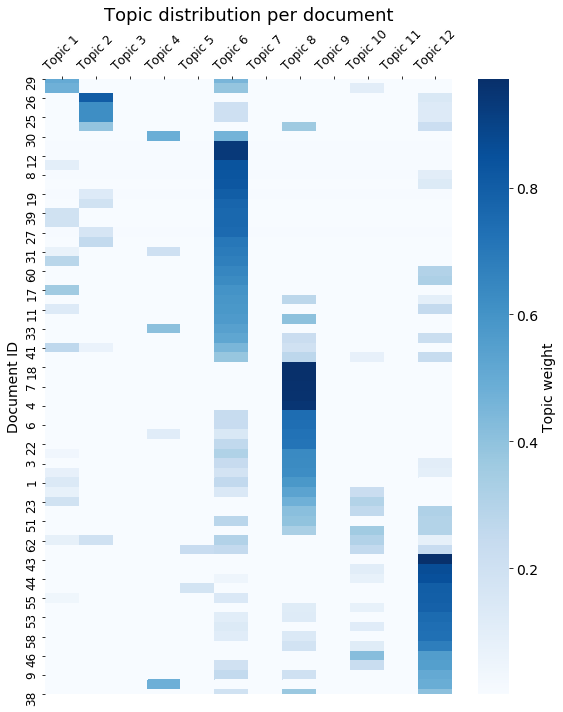

In [8]:
clustering.plot_topic_distribution(title="Topic distribution per document", 
                                   ylabel="Document ID", cmap='Blues')

In [9]:
sorted(Counter(document_clusters).items())

[(0, 2), (1, 4), (3, 1), (5, 23), (7, 17), (9, 3), (11, 15)]